# Архитектуры тестируемых моделей нейросетей (скорее всего сделать в виде обычного файла .py)

https://github.com/muhanzhang/pytorch_DGCNN

* https://arxiv.org/abs/1812.08434v4
* https://github.com/ShiYaya/graph


На основе https://arxiv.org/pdf/1606.09375.pdf

In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import pdb
from biopandas.pdb import PandasPdb
ppdb = PandasPdb()

import os
import time
import numpy as np
#import scipy
from scipy import sparse 
from scipy.sparse import linalg
#from tqdm.auto import tqdm
from tqdm import tqdm

In [46]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('seaborn-poster')
plt.rc('font', size=15)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=15)    # fontsize of the tick labels
plt.rc('ytick', labelsize=15)    # fontsize of the tick labels

In [3]:
import collections

if torch.cuda.is_available():
    print('cuda available')
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print('cuda not available')
    dtypeFloat = torch.FloatTensor
    dtypeLong = torch.LongTensor
    torch.manual_seed(1)
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device = {}'.format(device))

cuda not available
device = cpu


X – coordinates

A – adjacency matrices

y – cad-scores

**DATA format: {target_name}, {model_name}, {coordinates}, {adjacency_matrix}, {cad-score}**

In [4]:
DATA = np.load('../../data/data.npy', allow_pickle=True)

In [5]:
DATA_permuted = np.random.permutation(DATA)
print(DATA_permuted[:, 0])

['T0860' 'T0861' 'T0863' 'T0859' 'T0859' 'T0859' 'T0859' 'T0860' 'T0864'
 'T0859' 'T0862' 'T0859' 'T0862' 'T0859' 'T0866' 'T0859' 'T0859' 'T0859'
 'T0859' 'T0866' 'T0859' 'T0859' 'T0859' 'T0866' 'T0864' 'T0864' 'T0859'
 'T0859' 'T0862' 'T0859' 'T0859' 'T0859' 'T0859' 'T0864' 'T0860' 'T0862'
 'T0859' 'T0865' 'T0859' 'T0862' 'T0859' 'T0864' 'T0859' 'T0859' 'T0859'
 'T0865' 'T0859' 'T0859' 'T0864' 'T0859' 'T0859' 'T0859' 'T0865' 'T0866'
 'T0864' 'T0864' 'T0864' 'T0859' 'T0859' 'T0859' 'T0861' 'T0862' 'T0859'
 'T0866' 'T0860' 'T0864' 'T0861' 'T0859' 'T0860' 'T0859' 'T0859' 'T0860'
 'T0859' 'T0860' 'T0862' 'T0860' 'T0862' 'T0859' 'T0859' 'T0859' 'T0859'
 'T0859' 'T0861' 'T0859' 'T0864' 'T0860' 'T0862' 'T0865' 'T0859' 'T0866'
 'T0859' 'T0860' 'T0859' 'T0859' 'T0866' 'T0866' 'T0859' 'T0862' 'T0866'
 'T0862' 'T0859' 'T0859' 'T0859' 'T0859' 'T0859' 'T0860' 'T0866' 'T0866'
 'T0862' 'T0859' 'T0862' 'T0860' 'T0859' 'T0861' 'T0859' 'T0859' 'T0862'
 'T0860' 'T0859' 'T0860' 'T0859' 'T0864' 'T0859' 'T

In [6]:
'''
a = DATA_permuted[:, 0] == 'T0861'
b = DATA_permuted[:, 1] == 'chuo-u-server_TS2'
sum(np.logical_and(a, b))


DATA_859 = DATA[:104]
X_859 = DATA_859[:, 2]
indices_where988 = [i for i in range(len(X_859)) if X_859[i].shape[0] == 988]
newData = DATA_859[indices_where988]

newData_permut = np.random.permutation(newData)
'''

"\na = DATA_permuted[:, 0] == 'T0861'\nb = DATA_permuted[:, 1] == 'chuo-u-server_TS2'\nsum(np.logical_and(a, b))\n\n\nDATA_859 = DATA[:104]\nX_859 = DATA_859[:, 2]\nindices_where988 = [i for i in range(len(X_859)) if X_859[i].shape[0] == 988]\nnewData = DATA_859[indices_where988]\n\nnewData_permut = np.random.permutation(newData)\n"

In [7]:
def laplacian(A):
    '''
    A - adjacency matrix
    d - degree matrix 
    Return graph Laplacian
    '''
    d = A.sum(axis=0)
    d += np.spacing(np.array(0, A.dtype)) # добавление epsilon
    d = 1 / np.sqrt(d)
    D = sparse.diags(d.squeeze(), 0)
    I = sparse.identity(d.size, dtype=A.dtype)
    L = I - D * A * D

    assert np.abs(L - L.T).mean() < 1e-9
    #assert type(L) is sparse.csr.csr_matrix
    return L.A

def lmax_L(L):
    """Compute largest Laplacian eigenvalue"""
    return linalg.eigsh(L, k=1, which='LM', return_eigenvectors=False)[0]

# L с волной
def rescale_L(L, lmax=2):
    """Rescale Laplacian eigenvalues to [-1,1]"""
    M, M = L.shape
    I = sparse.identity(M, format='csr', dtype=L.dtype)
    L /= lmax
    L *= 2
    L -= I
    return L.A

In [16]:
%%time
test_adj = DATA_permuted[2][3]
L = laplacian(test_adj)
l_max = lmax_L(L)
L_hat = rescale_L(L, l_max)

print('l_max = {}'.format(l_max))

l_max = 1.4954649232167898
CPU times: user 14.1 s, sys: 1.19 s, total: 15.3 s
Wall time: 9.11 s


Получившаяся матрица сильно разреженная. Ненулевых элементов ~0-2%:

In [17]:
not_zero = sum(sum(L_hat != 0))
total = len(L_hat)**2
print('Ненулевых элементов: {}\nВсего элементов в матрице: {}'.format(not_zero, total))
print(str(round(100 * not_zero / total, 3)) + '%')

Ненулевых элементов: 49119
Всего элементов в матрице: 27008809
0.182%


In [32]:
class GraphConv(nn.Module):
    '''
    Graph Convolution Layer according to (T. Kipf and M. Welling, ICLR 2017)
    Additional tricks (power of adjacency matrix and weight self connections) as in the Graph U-Net paper
    '''
    def __init__(self,
                in_features,
                out_features,
                activation=None,
                adj_sq=False,
                scale_identity=False):
        super(GraphConv, self).__init__()
        self.fc = nn.Linear(in_features=in_features, out_features=out_features).double()
        self.adj_sq = adj_sq
        self.activation = activation
        self.scale_identity = scale_identity
            
    def laplacian_batch(self, A):
        
        batch, N = A.shape[:2]
        if self.adj_sq:
            A = torch.bmm(A, A)  # use A^2 to increase graph connectivity
        I = torch.eye(N).unsqueeze(0).double().to(device)
        if self.scale_identity:
            I = 2 * I  # increase weight of self connections
        A_hat = A + I
        D_hat = (torch.sum(A_hat, 1) + 1e-5) ** (-0.5)
        #print('-'*40)
        #print(batch)
        #print(A_hat.shape)
        #print(D_hat.shape)
        #print(D_hat.view(batch, N, 1).shape)
        #print('-'*40)
        L = D_hat.view(batch, N, 1) * A_hat * D_hat.view(batch, 1, N)
        return L

    def forward(self, data):
        x, A = data
        
        a = torch.bmm(self.laplacian_batch(A), x)
        #print(a.shape)
        x = self.fc(a.double())
        
        #print(x.shape)
        if self.activation is not None:
            x = self.activation(x)
        return (x, A)
        
class GCN(nn.Module):
    '''
    Baseline Graph Convolutional Network with a stack of Graph Convolution Layers and global pooling over nodes.
    '''
    def __init__(self,
                 in_features,
                 out_features,
                 filters=[64,64,64],
                 n_hidden=0,
                 dropout=0.2,
                 adj_sq=False,
                 scale_identity=False):
        super(GCN, self).__init__()

        # Graph convolution layers
        self.gconv = nn.Sequential(*([GraphConv(in_features=in_features if layer == 0 else filters[layer - 1], 
                                                out_features=f, 
                                                activation=nn.ReLU(inplace=True),
                                                adj_sq=adj_sq,
                                                scale_identity=scale_identity) for layer, f in enumerate(filters)]))
        
        # Fully connected layers
        fc = []
        if dropout > 0:
            fc.append(nn.Dropout(p=dropout))
        if n_hidden > 0:
            fc.append(nn.Linear(filters[-1], n_hidden))
            if dropout > 0:
                fc.append(nn.Dropout(p=dropout))
            n_last = n_hidden
        else:
            n_last = filters[-1]
        fc.append(nn.Linear(n_last, out_features))       
        self.fc = nn.Sequential(*fc).double()
        
    def forward(self, data):
        # X, A = data
        x = self.gconv(data)[0]
        x = torch.max(x, dim=1)[0].squeeze()  # max pooling over nodes
        x = self.fc(x)
        return x

In [33]:
model = GCN(in_features=3,
            out_features=1,
            n_hidden=0,
            filters=[64,64,64],
            dropout=0.2,
            adj_sq=False,
            scale_identity=False).to(device)

In [34]:
'''
separator=60
train_data = [list(newData_permut[:separator][i]) for i in range(len(newData_permut[:separator]))]
test_data = [list(newData_permut[separator:][i]) for i in range(len(newData_permut[separator:]))]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
'''
separator=190
train_data = [list(DATA_permuted[:separator][i]) for i in range(len(DATA_permuted[:separator]))]
test_data = [list(DATA_permuted[separator:][i]) for i in range(len(DATA_permuted[separator:]))]
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
print('train: {}\ntest: {}'.format(len(train_data), len(test_data)))

train: 190
test: 31


In [35]:
from scipy.stats import pearsonr, kendalltau, zscore

In [36]:
print('\nInitialize model')
print(model)

wdecay = 1e-4
lr = 0.005
epochs = 10
batch_size = 1

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=lr,
    weight_decay=wdecay,
    betas=(0.5, 0.999))
    
scheduler = lr_scheduler.MultiStepLR(optimizer, [20, 30], gamma=0.1)


def train(train_loader):
    scheduler.step()
    model.train()
    start = time.time()
    train_loss_ep = []
    n_samples = 0
    for batch_idx, data in enumerate(train_loader): 
        optimizer.zero_grad()
        output = model(data[2:4])
        loss = loss_fn(output, data[4])
        loss.backward()
        optimizer.step()
        time_iter = time.time() - start
        train_loss_ep.append(loss.item())
        n_samples += len(output)

        if batch_idx%40==0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} (avg: {:.6f}) \tsec/iter: {:.4f}'.format(
                epoch, n_samples, len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader), loss.item(), sum(train_loss_ep) / n_samples, time_iter / (batch_idx + 1) ))

    return train_loss_ep


def test(test_loader):
    model.eval()
    start = time.time()
    test_loss_ep = []
    correct, n_samples = 0, 0
    for batch_idx, data in enumerate(test_loader):
        #for i in range(len(data)):
        #    data[i] = data[i].to(device)
 
        output = model(data[2:4])
        loss = loss_fn(output, data[4])
        test_loss_ep.append(loss.item())
        n_samples += len(output)


    time_iter = time.time() - start
    print('Test set (epoch {}): Mean loss: {:.4f}\n'.format(epoch, np.mean(test_loss_ep)))
    return test_loss_ep

loss_fn = torch.nn.MSELoss()
mse_train_plot, mse_test_plot = [], []
for epoch in range(epochs):
    train_loss = train(train_loader)
    mse_train_plot.append(train_loss)
    test_loss = test(test_loader)
    mse_test_plot.append(test_loss)
    


Initialize model
GCN(
  (gconv): Sequential(
    (0): GraphConv(
      (fc): Linear(in_features=3, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
    (1): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
    (2): GraphConv(
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (activation): ReLU(inplace=True)
    )
  )
  (fc): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=64, out_features=1, bias=True)
  )
)
Train Epoch: 0 [1/190 (1%)]	Loss: 0.056568 (avg: 0.056568) 	sec/iter: 0.0822
Train Epoch: 0 [41/190 (22%)]	Loss: 6.076685 (avg: 5.466421) 	sec/iter: 0.2104
Train Epoch: 0 [81/190 (43%)]	Loss: 2.928307 (avg: 3.118014) 	sec/iter: 0.2275
Train Epoch: 0 [121/190 (64%)]	Loss: 0.017901 (avg: 2.308981) 	sec/iter: 0.2599
Train Epoch: 0 [161/190 (85%)]	Loss: 0.173495 (avg: 1.793983) 	sec/iter: 0.2380
Test set (epoch 0): Mean loss: 0.0564

Train Epo

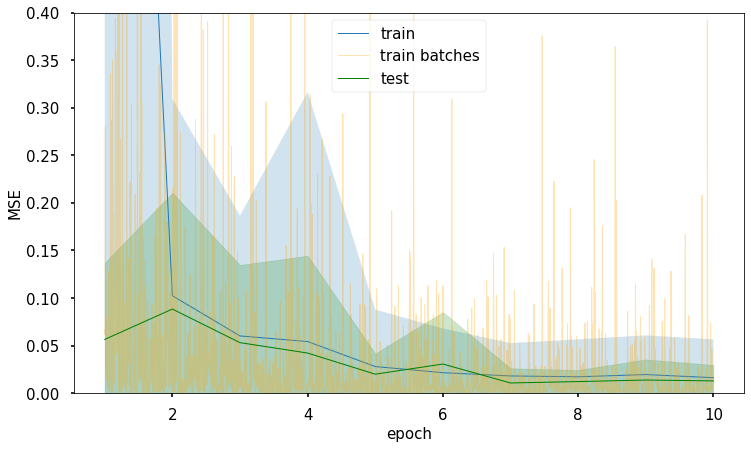

In [101]:
tr = np.array(mse_train_plot).flatten()

plt.figure(figsize=(12, 7))
axes = plt.gca()
axes.set_ylim([0,0.4])

plt.plot((np.arange(10)+1), np.mean(mse_train_plot,1), lw=1, linestyle='-', label='train', alpha=2)
plt.fill_between((np.arange(10)+1), np.mean(mse_train_plot, 1)  + np.std(mse_train_plot, 1) , 
                 np.mean(mse_train_plot, 1) - np.std(mse_train_plot, 1), 
                 alpha = 0.2)


plt.plot((np.arange(len(tr))/190)[190:], tr[190:], 
         lw=1, linestyle='-', label='train batches', color='orange', alpha=0.3)

plt.plot((np.arange(10)+1), np.mean(mse_test_plot,1), lw=1, linestyle='-', label='test', color='green') 
plt.fill_between((np.arange(10)+1), np.mean(mse_test_plot, 1)  + np.std(mse_test_plot, 1) , 
                 np.mean(mse_test_plot, 1) - np.std(mse_test_plot, 1), color='green',
                 alpha = 0.2)

plt.xlabel('epoch')
plt.ylabel('MSE')
plt.legend(loc="best", prop={'size': 15})

plt.savefig('./training.pdf')
plt.show()